Тут про постановку задачи, почему это важно и прочее.

# Problem statement
![image](./figures/Aero_Composite_Applications.png)

# Thermoset resin curing
![image](./figures/molleculas.png)

# Data collecting
![image](./figures/DSC_polyma.jpg)
![image](./figures/DSC_incide.jpg)

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.integrate import simps

%matplotlib inline

Подгружаем данные

In [276]:
df = pd.read_csv('data/ExpDat_SK_Clear_resin_entalp5kpm_20-150.txt', sep='\t',comment='#')
df.columns = ['Temp', 'Time', 'DSC', 'Sence']

df.head()

,Temp,Time,DSC,Sence
0,20.01794,0.01,0.022839,3.36733
1,20.01857,0.02,0.022820,3.36733
2,20.02401,0.03,0.022770,3.36734
3,20.03631,0.04,0.022824,3.36735
4,20.05572,0.05,0.023849,3.36737


Text(0.5, 1.0, 'Raw cure kinetics signal by temperature')

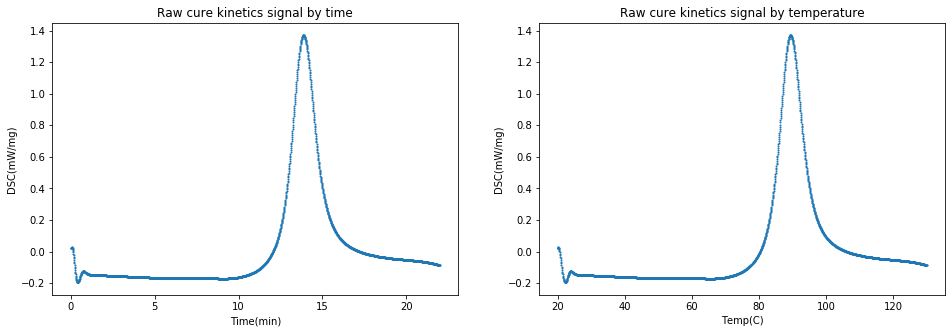

In [277]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].plot(df['Time'], df['DSC'], "o", markersize=1)
ax[0].set_title('Raw cure kinetics signal by time')

ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].plot(df['Temp'], df['DSC'], "o", markersize=1)
ax[1].set_title('Raw cure kinetics signal by temperature')

### Тут ищем точки начала и конца реакции

Давай по искать точки начала и конца пика по температуре - так будет удобнее. На этом графике он будет где-то от 60 до 110. Вообще отделюную часть кода нужно уделить определению точек начала и конца. Я пытался сделать это автоматически красиво, но получилось так себе. Наверное лучше составить отдельную таблицу и захардкодить.

[0.09091179, 0.08824617]


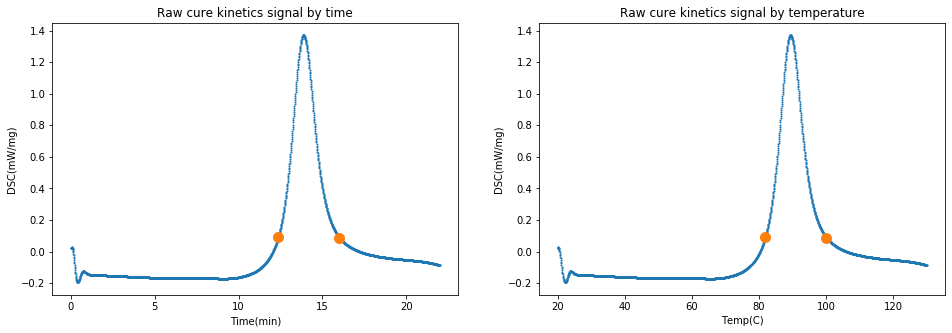

In [278]:
def find_peak(df):
    peaks_positive, _ = find_peaks(df['DSC'], height=1.2)
    peaks_width, width_heights, _, _ = peak_widths(df['DSC'], peaks_positive, rel_height = 0.88)

    peak_start = df['DSC'][df['DSC']>width_heights[0]].first_valid_index()
    peak_end = df['DSC'][df['DSC']>width_heights[0]].last_valid_index()

    print([df['DSC'][peak_start],df['DSC'][peak_end]])

    fig, ax = plt.subplots(1, 2, figsize = (16, 5))
    ax[0].plot(df['Time'], df['DSC'], "o", markersize=1, label = "Signal")
    ax[0].plot([df['Time'][peak_start],df['Time'][peak_end]],
                   [df['DSC'][peak_start],df['DSC'][peak_end]],
                  "o", markersize=10, label = "Baseline")
    ax[0].set_xlabel("Time(min)")
    ax[0].set_ylabel('DSC(mW/mg)')
    ax[0].set_title('Raw cure kinetics signal by time')

    ax[1].plot(df['Temp'], df['DSC'], "o", markersize=1, label = "Signal")
    ax[1].plot([df['Temp'][peak_start],df['Temp'][peak_end]],
                   [df['DSC'][peak_start],df['DSC'][peak_end]],
                    "o", markersize=10, label = "Baseline")
    ax[1].set_xlabel("Temp(C)")
    ax[1].set_ylabel('DSC(mW/mg)')
    ax[1].set_title('Raw cure kinetics signal by temperature')
    
    return peak_start, peak_end

peak_start, peak_end = find_peak(df)

Строим бейслайн по точкам начала и конца, режем пик, приводим к бейслайну

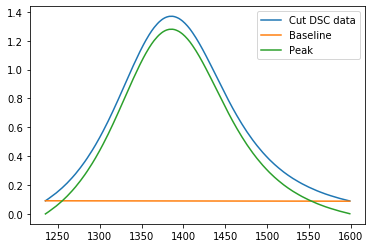

In [279]:
def calc_peak(df, peak_start, peak_end):
    baseline = np.zeros(0)

    for i in range(peak_end - peak_start):  # строим baseline
        new_val = (df['DSC'][peak_end] - df['DSC'][peak_start])/(peak_end - peak_start)*i + df['DSC'][peak_start]
        baseline = np.append(baseline,new_val)

    peak = df['DSC'][peak_start: peak_end] - baseline

    plt.plot(df['DSC'][peak_start: peak_end], label = "Cut DSC data")
    plt.plot(range(peak_start, peak_end), baseline, label = "Baseline")
    plt.plot(range(peak_start, peak_end), peak, label = "Peak")
    plt.legend()
    
    return peak

peak = calc_peak(df, peak_start, peak_end)

По приведенному к бейслайну пику строим альфу - степень полимеризации

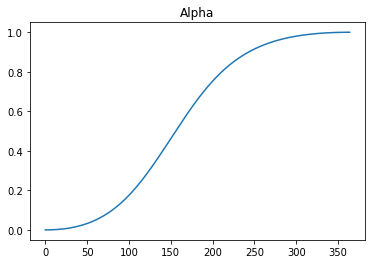

In [280]:
def calc_alpha(peak):
    spent_energy = simps(peak)
    alpha = []

    for i,_ in enumerate(peak):
        alpha.append(simps(peak[:i+1])/spent_energy)
    plt.plot(alpha)
    plt.title('Alpha')
    
    return alpha

alpha = calc_alpha(peak)

Наверное тут стоит начать создавать датафрейм, где будет только только пик + добавить к нему колонку альфы и $\frac{d\alpha}{dt}$

In [281]:
def extract_data(df, peak_start, peak_end, alpha):

    dt = []
    dalpha = []
    dalpha_dt = []
    temp = []
    dtemp = []
    dalpha_dtemp = []

    for i in range(peak_end - peak_start):
        dt.append((df['Time'][i+1] - df['Time'][i]) * 60)
        temp.append(df['Temp'][i] + 237)
        dtemp.append(df['Temp'][i+1] - df['Temp'][i])

    dalpha.append(0)
    for i in range(len(alpha)-1):
        dalpha.append(alpha[i+1] - alpha[i])

    for i in range(len(dalpha)):
        dalpha_dt.append(dalpha[i]/dt[i])

    for i in range(len(dalpha)):
        dalpha_dtemp.append(dalpha[i]/dtemp[i])

    data = {'alpha' : alpha, 
            'dtime' : dt, 
            'dalpha' : dalpha, 
            'dalpha_dtime' : dalpha_dt, 
            'time' : df['Time'][peak_start:peak_end], 
            'peak' : peak,
            'temp' : temp,
            'dtemp' : dtemp,#разве что как фича для новых регрессий
            'dalpha_dtemp' : dalpha_dtemp,
           }

    processed_df = pd.DataFrame(data, columns = ['alpha', 'dtime', 'dalpha', 'dalpha_dtime', 'time', 'peak', 'temp', 'dtemp', 'dalpha_dtemp'])
    processed_df.drop(processed_df.head(1).index, inplace=True)
    processed_df.drop(processed_df.tail(1).index, inplace=True)
    processed_df.head()
    
    return processed_df

# Classic ways to silulate resin curing

Уравнения, с помощью которых мы рассчитываем степень полимеризации.

$$\frac{d\alpha}{dt} = Ae^{-\frac{E_a}{RT}}(1-\alpha)^n \alpha^m$$

Логарифмируем, получим:
$$\ln(\frac{d\alpha}{dt}) = \ln(A) - \frac{E_a}{RT} + n \ln(1-\alpha) + m \ln(\alpha)$$

Для поиска коэффициентов уравнения можно применить мультилинейную регрессию.
Нам известны значения ${d\alpha}\over{dt}$, $\alpha$. Довольно просто можно рассчитать логарифмы этих значений. Также нам известны данные о температуре, при которой проходит реакция. Мы можем определить параметры поиска на основе известных данных, построить регрессию, а затем получить ее коэффициенты. Эти коэффициенты и будут неизвестными параметрами смолы.


In [282]:
from sklearn import linear_model

processed_df = extract_data(df, peak_start, peak_end, alpha)

R = 8.314

a = np.ones(processed_df['alpha'].count()) #собираем матрицу коэффицентов
b = np.array(-1 / (R * processed_df['temp']))
c = np.array(np.log(1 - processed_df['alpha']))
d = np.log(processed_df['alpha'])
X = np.vstack([a, b, c, d])
#X = np.vstack([a, b, c])
X = X.transpose()

y = np.log(processed_df['dalpha_dtime'])

lm_regr = linear_model.LinearRegression(fit_intercept=False, normalize=True)
lm_regr.fit(X, y)

print("A = ", np.exp(lm_regr.coef_[0]))
print("E_a = ", lm_regr.coef_[1])
print("n = ", lm_regr.coef_[2])
print("m =", lm_regr.coef_[3])


A =  1.6870960496355228e-12
E_a =  -51345.63938600094
n =  0.5543047338930092
m = 0.7258293416846866


In [283]:
#print(processed_df["pred_dalpha"])
def calc_predicted_alpha(daplpa, dt):
    alpha = []
    alpha.append(0)
    for i in range(len(daplpa)):
        alpha.append(alpha[-1] + daplpa[i]*dt[i])
    return alpha

#pred_alpha = calc_alpha(processed_df["pred_dalpha"], processed_df["dtime"])

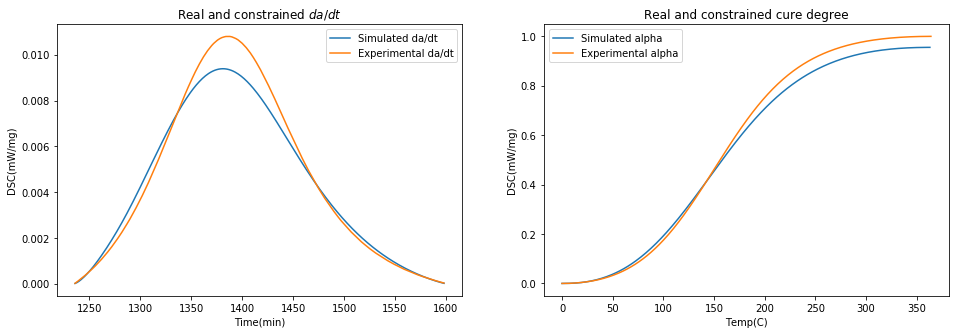

In [284]:
processed_df["pred_dalpha_dtime"] =  np.exp(lm_regr.predict(X))

pred_alpha = []
pred_alpha.append(0)
for i in range(len(processed_df)):
    pred_alpha.append(pred_alpha[-1] + 
                      processed_df.iloc[i][-1]*processed_df.iloc[i][1])#d_alpha * dt
    
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(processed_df["pred_dalpha_dtime"], label = "Simulated da/dt")
ax[0].plot(processed_df["dalpha_dtime"], label = "Experimental da/dt")

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].set_title('Real and constrained $da/dt$')
ax[0].legend()


ax[1].plot(pred_alpha, label = "Simulated alpha")
ax[1].plot(alpha, label = "Experimental alpha")

ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].set_title('Real and constrained cure degree')
ax[1].legend()


Тут написать подробно про метрики, и выбрать ошибку (MSE r2)

Дальше начинаем трогать другие модели?

Разделим данные на фичи и таргет

In [285]:
processed_df.head()

,alpha,dtime,dalpha,dalpha_dtime,time,peak,temp,dtemp,dalpha_dtemp,pred_dalpha_dtime
1236,0.000009,0.6,0.000009,0.000016,12.37,0.003743,257.01857,0.00544,0.001742,0.000010
1237,0.000038,0.6,0.000029,0.000048,12.38,0.007540,257.02401,0.01230,0.002319,0.000028
1238,0.000087,0.6,0.000049,0.000081,12.39,0.011680,257.03631,0.01941,0.002501,0.000052
1239,0.000156,0.6,0.000070,0.000116,12.40,0.015847,257.05572,0.02649,0.002635,0.000079
1240,0.000247,0.6,0.000091,0.000151,12.41,0.020095,257.08221,0.03327,0.002731,0.000110


In [286]:
#X = processed_df.drop(columns="dalpha_dtime")#
X = processed_df[["alpha", "temp"]]
y = processed_df["dalpha_dtime"]

Text(0.5, 1.0, '$da/dt$ distribution')

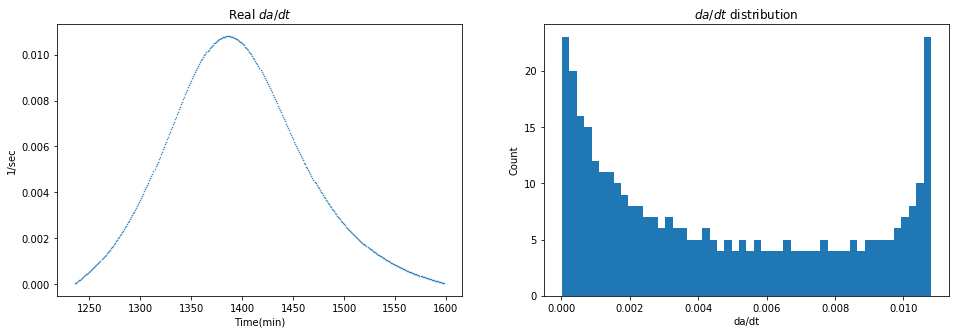

In [287]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(y, ".", markersize = 1, label = "Experimental da/dt")

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('1/sec')
ax[0].set_title('Real $da/dt$')

ax[1].hist(y, bins = 50)
ax[1].set_xlabel("da/dt")
ax[1].set_ylabel('Count')
ax[1].set_title('$da/dt$ distribution')

Данные распределены не нормально. Что это нам дает? Модем ли мы уже здесь сказать, что линейная регрессия прям не зайдет?

In [288]:
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2)

In [289]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

lr = linear_model.LinearRegression(fit_intercept=False, normalize=True)
lr.fit(X_train, y_train)

test_pred = lr.predict(X_test)
train_pred = lr.predict(X_train)

test_pred = lr.predict(X_test)
train_pred = lr.predict(X_train)

mse_lr_train =  mean_squared_error(y_train, train_pred)
mse_lr_test =  mean_squared_error(y_test, test_pred)

r2_score_train = r2_score(y_train, train_pred)
r2_score_test =  r2_score(y_test, test_pred)

print(mse_lr_test, mse_lr_train)
print(r2_score_test, r2_score_train)

1.408911179288022e-05 1.2621087803548325e-05
0.03226361208363826 0.030945581921480114


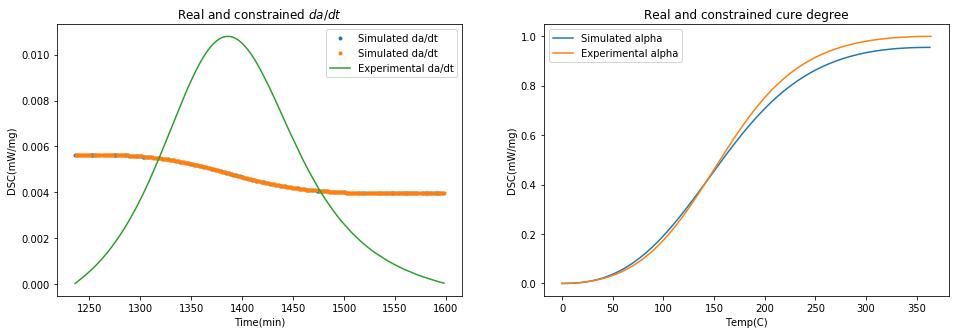

In [290]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

test_pred_visualised = pd.Series(test_pred, index=X_test.index)
train_pred_visualised = pd.Series(train_pred, index = X_train.index)

ax[0].plot(test_pred_visualised,".", label = "Simulated da/dt")
ax[0].plot(train_pred_visualised, ".", label = "Simulated da/dt")
ax[0].plot(y, label = "Experimental da/dt")

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].set_title('Real and constrained $da/dt$')
ax[0].legend()

ax[1].plot(pred_alpha, label = "Simulated alpha")
ax[1].plot(alpha, label = "Experimental alpha")

ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].set_title('Real and constrained cure degree')
ax[1].legend()

Результаты очень плохие. Пробуем решить полиномом.

In [291]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

poly = make_pipeline(PolynomialFeatures(degree=3), LinearRegression(fit_intercept=False))
poly.fit(X, y)

test_pred = poly.predict(X_test)
train_pred = poly.predict(X_train)

test_pred = poly.predict(X_test)
train_pred = poly.predict(X_train)

mse_lr_train =  mean_squared_error(y_train, train_pred)
mse_lr_test =  mean_squared_error(y_test, test_pred)

r2_score_train = r2_score(y_train, train_pred)
r2_score_test =  r2_score(y_test, test_pred)

print(mse_lr_test, mse_lr_train)# ошибку лучше считать по альфе, а не d_aplha (Y)
print(r2_score_test, r2_score_train)

1.5466592242209779e-10 6.5198206269895e-11
0.9999893764885042 0.9999949940440301


Результат гораздо лучше. По хорошему дальше нужно показать графики того какую dalpha/dt и саму alpha(t) мы предстказали. Но я помудохался с ними и ничего красивого не получил. Если сможем нормально считать альфу, то лучше считать ошибку по ней

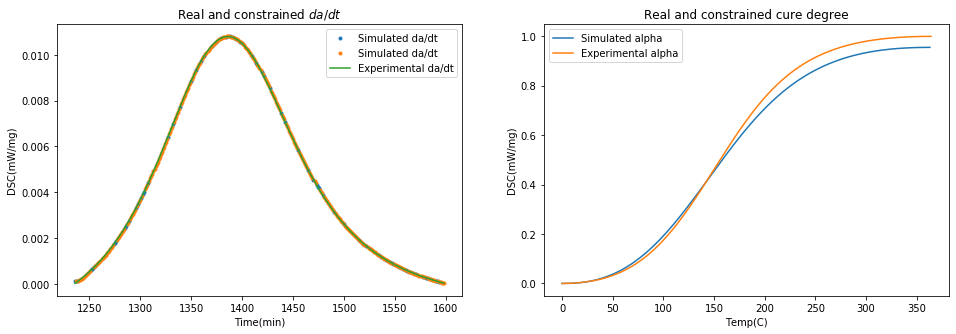

In [292]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

test_pred_visualised = pd.Series(test_pred, index=X_test.index)
train_pred_visualised = pd.Series(train_pred, index = X_train.index)

ax[0].plot(test_pred_visualised,".", label = "Simulated da/dt")
ax[0].plot(train_pred_visualised, ".", label = "Simulated da/dt")
ax[0].plot(y, label = "Experimental da/dt")
ax[0].legend()

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].set_title('Real and constrained $da/dt$')

ax[1].plot(pred_alpha, label = "Simulated alpha")
ax[1].plot(alpha, label = "Experimental alpha")

ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].set_title('Real and constrained cure degree')
ax[1].legend()

Делаем Kfold для этой модели, получаем ухудшение

In [293]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

mse_cross_val = cross_val_score(poly, X, y, cv = 4, scoring=make_scorer(mean_squared_error))
print(mse_cross_val.mean())
r2_cross_val = cross_val_score(poly, X, y, cv = 4, scoring='r2')
print(r2_cross_val.mean())


3.08526965526686e-06
-1.11149341494567


Затем найдем грид серчем оптимальные параметры пайплайна - результат улучшится

In [294]:
from sklearn.model_selection import GridSearchCV

parameters = {'polynomialfeatures__degree' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}

clf = GridSearchCV(poly, parameters, cv=5, iid='False')
clf.fit(X, y)
print(clf.best_params_)

{'polynomialfeatures__degree': 4}


Видим, что оптимальный показатель степени для PolynomialFeatures равен тому, который мы выбрали изначально. 
Переучивать модель не нужно. Протестируем модель на более широком датасете.

[0.09091179, 0.08824617]
[0.10305, 0.10209]
[0.09012947, 0.08921658]
         alpha  dtime    dalpha  dalpha_dtime   time      peak       temp  \
1236  0.000009    0.6  0.000009      0.000016  12.37  0.003743  257.01857   
1237  0.000038    0.6  0.000029      0.000048  12.38  0.007540  257.02401   
1238  0.000087    0.6  0.000049      0.000081  12.39  0.011680  257.03631   
1239  0.000156    0.6  0.000070      0.000116  12.40  0.015847  257.05572   
1240  0.000247    0.6  0.000091      0.000151  12.41  0.020095  257.08221   
1241  0.000359    0.6  0.000112      0.000187  12.42  0.024022  257.11548   
1242  0.000491    0.6  0.000132      0.000219  12.43  0.028099  257.15536   
1243  0.000645    0.6  0.000154      0.000256  12.44  0.032587  257.20107   
1244  0.000821    0.6  0.000176      0.000293  12.45  0.036974  257.25194   
1245  0.001019    0.6  0.000198      0.000330  12.46  0.041231  257.30736   
1246  0.001239    0.6  0.000220      0.000367  12.47  0.045829  257.36659   
1247  0

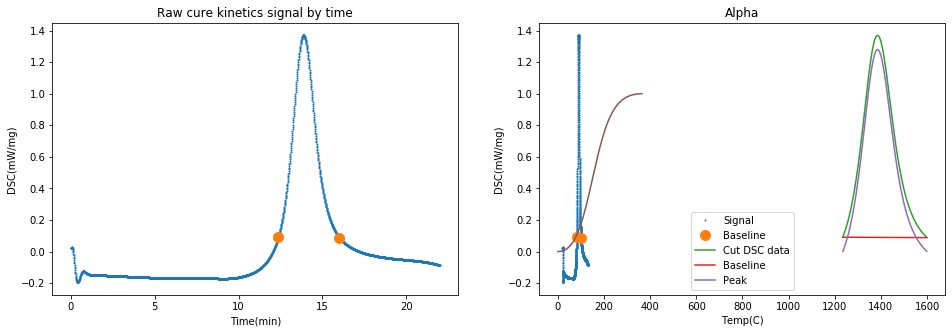

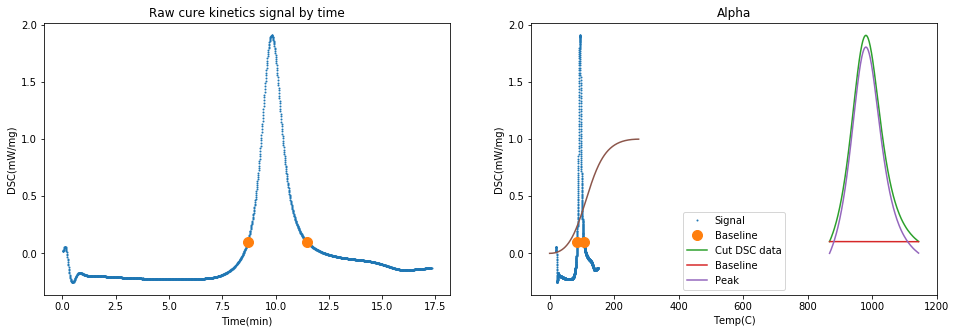

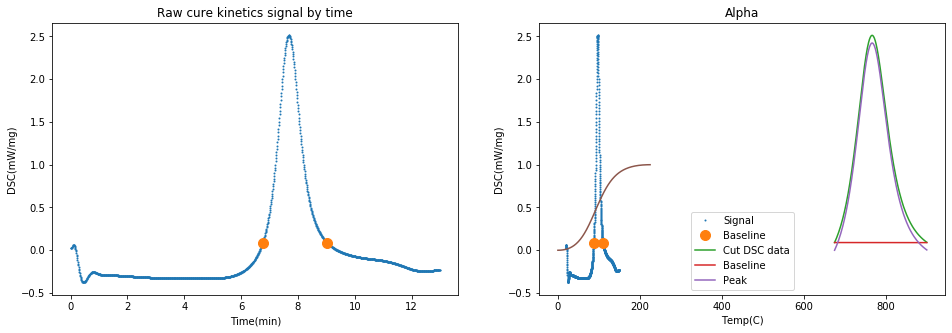

In [297]:
all_files = ['data/ExpDat_SK_Clear_resin_entalp5kpm_20-150.txt', 
             'data/ExpDat_SK_Clear_resin_entalp75kpm_20-150.txt',
             'data/ExpDat_SK_Clear_resin_entalp10kpm_20-150.txt',]
li = []
peaks = []

for filename in all_files:
    df = pd.read_csv(filename, sep='\t',comment='#')
    df.columns = ['Temp', 'Time', 'DSC', 'Sence']
    peak_start, peak_end = find_peak(df)
    peaks.append([peak_start, peak_end])
    peak = calc_peak(df, peak_start, peak_end)
    alpha = calc_alpha(peak)
    li.append(extract_data(df, peak_start, peak_end, alpha))

print(li[0])
